In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions

In [2]:
def get_distance(point1, point2):
    from math import atan2, cos, radians, sin, sqrt

    R = 6370
    lat1 = radians(point1[0])  # insert value
    lon1 = radians(point1[1])
    lat2 = radians(point2[0])
    lon2 = radians(point2[1])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance


# Modelos de classificação

## Importando os Dados

In [3]:
tb_atrasos = pd.read_csv("data/tb_atraso_olist.csv")

In [4]:
tb_atrasos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105387 entries, 0 to 105386
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       105387 non-null  object 
 1   product_id                     105387 non-null  object 
 2   seller_id                      105387 non-null  object 
 3   order_status                   105387 non-null  object 
 4   price                          105387 non-null  float64
 5   freight_value                  105387 non-null  float64
 6   customer_state                 105387 non-null  object 
 7   seller_state                   105387 non-null  object 
 8   product_category_name          103906 non-null  object 
 9   product_weight_g               105370 non-null  float64
 10  order_purchase_timestamp       105387 non-null  object 
 11  order_estimated_delivery_date  105387 non-null  object 
 12  order_delivered_customer_date 

In [5]:
pre_limpeza = tb_atrasos.shape[0]
tb_atrasos = tb_atrasos.dropna()
print(f"Num. linhas descartadas {pre_limpeza - tb_atrasos.shape[0]}")


Num. linhas descartadas 1490


In [6]:
tb_atrasos["dist"] = tb_atrasos.apply(
    lambda x: get_distance(
        (x["buyer_lat"], x["buyer_long"]), (x["seller_lat"], x["seller_long"])
    ),
    axis=1,
)


In [7]:
tb_atrasos["dt_compra"] = pd.to_datetime(tb_atrasos["order_purchase_timestamp"])
tb_atrasos["dt_real"] = pd.to_datetime(tb_atrasos["order_delivered_customer_date"])
tb_atrasos["dt_prevista"] = pd.to_datetime(tb_atrasos["order_estimated_delivery_date"])
tb_atrasos["dias_previstos"] = (
    tb_atrasos["dt_prevista"] - tb_atrasos["dt_compra"]
).dt.total_seconds() / (60 * 60 * 24)
tb_atrasos["dias_atraso"] = (
    tb_atrasos["dt_real"] - tb_atrasos["dt_prevista"]
).dt.total_seconds() / (60 * 60 * 24)
tb_atrasos["atraso_bin"] = np.where(tb_atrasos["dias_atraso"] >= 1, 1, 0)

In [8]:
tb_atrasos.columns

Index(['order_id', 'product_id', 'seller_id', 'order_status', 'price',
       'freight_value', 'customer_state', 'seller_state',
       'product_category_name', 'product_weight_g', 'order_purchase_timestamp',
       'order_estimated_delivery_date', 'order_delivered_customer_date',
       'seller_lat', 'seller_long', 'buyer_lat', 'buyer_long', 'dist',
       'dt_compra', 'dt_real', 'dt_prevista', 'dias_previstos', 'dias_atraso',
       'atraso_bin'],
      dtype='object')

In [9]:
tb_atrasos.head()


,order_id,product_id,seller_id,order_status,price,freight_value,customer_state,seller_state,product_category_name,product_weight_g,...,seller_long,buyer_lat,buyer_long,dist,dt_compra,dt_real,dt_prevista,dias_previstos,dias_atraso,atraso_bin
0,0a9a43ac5fe59c6c4bee2a8f9b9fcce8,c1aabbb6f4caec9f5bf7cd80519d6cc0,579891617139df7d8671d373f0669622,delivered,39.90,18.38,MG,RJ,livros_interesse_geral,400.0,...,-43.356193,-18.483290,-47.407009,647.153411,2018-07-02,2018-07-10,2018-07-27,25.0,-17.0,0
1,50ba38c4dc467baab1ea2c8c7747934d,418d480693f2f01e9cf4568db0346d28,12b9676b00f60f3b700e83af21824c0e,delivered,199.00,20.63,MG,RS,cool_stuff,1950.0,...,-51.462948,-18.483290,-47.407009,1312.090841,2018-03-02,2018-03-24,2018-04-09,38.0,-16.0,0
2,d99e6849f7676dade195f20c26f0eb4f,1081ae52311daac87fb54ba8ce4670ac,4371b634e0efc0e22b09b52907d9d469,delivered,120.00,15.59,MG,SP,esporte_lazer,300.0,...,-46.634196,-18.483290,-47.407009,570.593752,2017-09-02,2017-09-08,2017-09-26,24.0,-18.0,0
3,3f1294f87d79b57f5d55ba7b80c3d94f,0a9b9a871ffaec6c0198334558a6c6a1,f9244d45189d3a3605499abddeade7d5,delivered,949.99,75.53,GO,SP,eletroportateis,12600.0,...,-46.634196,-16.192659,-48.713166,847.880472,2018-01-28,2018-02-26,2018-03-14,45.0,-16.0,0
4,2eecb0d85f281280f79fa00f9cec1a95,4fd676d9c4723d475026e40aeae56957,5fd924b4836098a5be0ecf81ba054ce0,delivered,135.00,19.23,MG,SP,ferramentas_jardim,4300.0,...,-46.634196,-19.160800,-45.452073,504.666874,2017-02-17,2017-03-03,2017-03-20,31.0,-17.0,0


In [10]:
tb_atrasos.groupby("atraso_bin")[["dist", "dias_previstos"]].mean()

,dist,dias_previstos
atraso_bin,,
0,581.087022,24.477951
1,761.439496,23.210496


In [11]:
tb_atrasos[["dist", "dias_previstos"]].quantile([0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 1])

,dist,dias_previstos
0.05,0.000000,11.0
0.25,179.332907,19.0
0.50,430.267255,24.0
0.75,789.539770,29.0
0.95,2088.842597,39.0
0.99,2475.172228,51.0
1.00,8676.594130,156.0


In [12]:
q99_dist = np.quantile(tb_atrasos['dist'], 0.99)
q99_dias = np.quantile(tb_atrasos['dias_previstos'], 0.99)
mask_outlier = (tb_atrasos['dist'] < q99_dist) & (tb_atrasos['dias_previstos'] < q99_dias)
tb_atrasos_nout = tb_atrasos[mask_outlier].copy()

In [13]:
tb_atrasos_nout.shape[0] - tb_atrasos.shape[0]

-2096

In [15]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(tb_atrasos[["dist", "dias_previstos"]]), columns = ["dist", "dias_previstos"])
y = tb_atrasos["atraso_bin"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


O que foi feito de errado? **LEAKAGE NA SEPARAÇÃO TEST E TRAIN**

# Regressão Logística (Modelo Baseline)

In [16]:
from sklearn.linear_model import LogisticRegression


In [17]:
log_fit = LogisticRegression()
log_fit.fit(X_train, y_train)


LogisticRegression()

/Users/pedroteche/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


<AxesSubplot:>

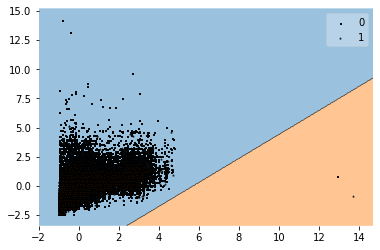

In [18]:
plot_decision_regions(
    np.array(X_train), np.array(y_train), log_fit, scatter_kwargs={"alpha": 1, "s": 1}
)


In [19]:
vetor_dist = np.linspace(X_train["dist"].min(), X_train["dist"].max(), 200)
vetor_peso = [X_train["dias_previstos"].median()] * 200
tb_simul_dist = pd.DataFrame({"dist": vetor_dist, "dias_previstos": vetor_peso})
tb_simul_dist["prob_atraso_log"] = log_fit.predict_proba(tb_simul_dist)[:, -1]


In [20]:
vetor_peso = np.linspace(
    X_train["dias_previstos"].min(), X_train["dias_previstos"].max(), 200
)
vetor_dist = [X_train["dist"].median()] * 200
tb_simul_peso = pd.DataFrame({"dist": vetor_dist, "dias_previstos": vetor_peso})
tb_simul_peso["prob_atraso_log"] = log_fit.predict_proba(tb_simul_peso)[:, -1]


Text(0.5, 0.98, 'Simulações usando Modelo Baseline (Reg. Log.)')

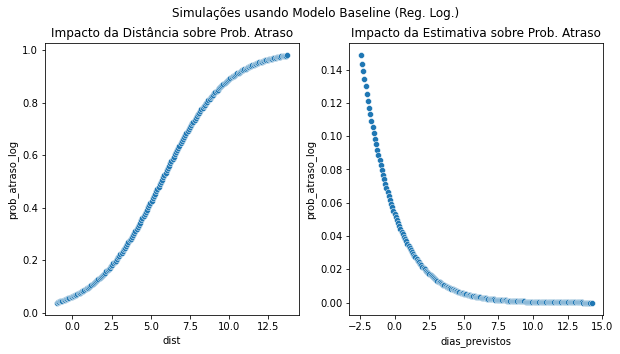

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(data=tb_simul_dist, x="dist", y="prob_atraso_log", ax=ax[0])
sns.scatterplot(data=tb_simul_peso, x="dias_previstos", y="prob_atraso_log", ax=ax[1])
ax[0].set_title("Impacto da Distância sobre Prob. Atraso")
ax[1].set_title("Impacto da Estimativa sobre Prob. Atraso")
fig.suptitle("Simulações usando Modelo Baseline (Reg. Log.)")


In [22]:
pred_test = log_fit.predict(X_test)
tb_p_test = pd.DataFrame({"y_real": y_test, "pred_reglog": pred_test})


In [23]:
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
)

In [24]:
print(f"Acurácia: {accuracy_score(tb_p_test['y_real'], tb_p_test['pred_reglog'])}")
print(f"ROC-AUC Score: {roc_auc_score(tb_p_test['y_real'], tb_p_test['pred_reglog'])}")
print(f"Precision: {precision_score(tb_p_test['y_real'], tb_p_test['pred_reglog'])}")
print(f"Recall: {recall_score(tb_p_test['y_real'], tb_p_test['pred_reglog'])}")
print(f"F1-Score: {f1_score(tb_p_test['y_real'], tb_p_test['pred_reglog'])}")


Acurácia: 0.9345524542829644
ROC-AUC Score: 0.5002939447383892
Precision: 1.0
Recall: 0.0005878894767783657
F1-Score: 0.0011750881316098707


In [25]:
f1_score(y_train, log_fit.predict(X_train))

0.00038895371450797355

In [34]:
def calcular_erros(nome_coluna_pred):
    print(
        f"Acurácia: {accuracy_score(tb_p_test['y_real'], tb_p_test[nome_coluna_pred])}"
    )
    print(
        f"ROC-AUC Score: {roc_auc_score(tb_p_test['y_real'], tb_p_test[nome_coluna_pred])}"
    )
    print(
        f"Precision: {precision_score(tb_p_test['y_real'], tb_p_test[nome_coluna_pred])}"
    )
    print(f"Recall: {recall_score(tb_p_test['y_real'], tb_p_test[nome_coluna_pred])}")
    print(f"F1-Score: {f1_score(tb_p_test['y_real'], tb_p_test[nome_coluna_pred])}")


O que aconteceu com o modelo de regressão? Como poderíamos melhora-lo?

# kNN

In [27]:
from sklearn.neighbors import KNeighborsClassifier

![title](knn.png)

## Hiperparâmetros
* **n_neighbors** : Número de vizinhos
* **weights** : Metodologia de ponderação dos vizinhos (devo penalizar vizinhos mais distantes?).
* **metric** : Função de distância utilizada para 'escolher' vizinhos mais próximos.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.DistanceMetric.html#sklearn.metrics.DistanceMetric
![title](metrica_distancia.png)

In [28]:
knn_fit = KNeighborsClassifier(n_neighbors=1)
knn_fit.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=1)

/Users/pedroteche/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


<AxesSubplot:>

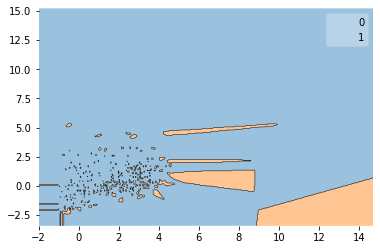

In [29]:
plot_decision_regions(
    np.array(X_train), np.array(y_train), knn_fit, scatter_kwargs={"alpha": 0, "s": 1}
)


In [30]:
tb_simul_dist.columns

Index(['dist', 'dias_previstos', 'prob_atraso_log'], dtype='object')

In [31]:
tb_simul_dist["prob_atraso_knn"] = knn_fit.predict_proba(
    tb_simul_dist[["dist", "dias_previstos"]]
)[:, -1]
tb_simul_peso["prob_atraso_knn"] = knn_fit.predict_proba(
    tb_simul_peso[["dist", "dias_previstos"]]
)[:, -1]


Text(0.5, 0.98, 'Simulações usando Modelo Baseline (Reg. Log.)')

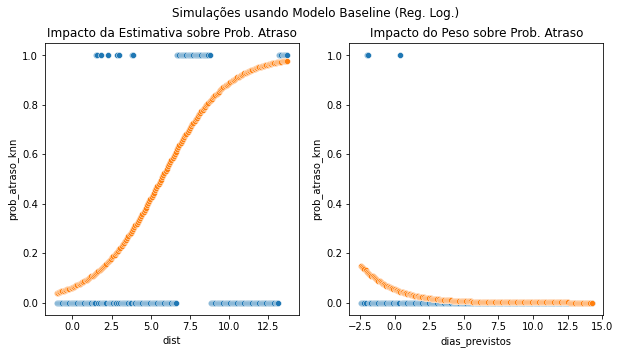

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(data=tb_simul_dist, x="dist", y="prob_atraso_knn", ax=ax[0])
sns.scatterplot(data=tb_simul_dist, x="dist", y="prob_atraso_log", ax=ax[0])
sns.scatterplot(data=tb_simul_peso, x="dias_previstos", y="prob_atraso_knn", ax=ax[1])
sns.scatterplot(data=tb_simul_peso, x="dias_previstos", y="prob_atraso_log", ax=ax[1])
ax[0].set_title("Impacto da Estimativa sobre Prob. Atraso")
ax[1].set_title("Impacto do Peso sobre Prob. Atraso")
fig.suptitle("Simulações usando Modelo Baseline (Reg. Log.)")


In [35]:
tb_p_test["pred_knn"] = knn_fit.predict(X_test)
calcular_erros("pred_knn")

Acurácia: 0.888354186717998
ROC-AUC Score: 0.5682406260642691
Precision: 0.1809473124002129
Recall: 0.19988242210464433
F1-Score: 0.18994413407821226


In [36]:
for i in range(1, 10):
    knn_fit = KNeighborsClassifier(n_neighbors=i)
    knn_fit.fit(X_train, y_train)
    print(f"{i}-NN F1 = {f1_score(y_test, knn_fit.predict(X_test))}")


1-NN F1 = 0.18994413407821226
2-NN F1 = 0.10694652673663169
3-NN F1 = 0.13084112149532712
4-NN F1 = 0.06119162640901771
5-NN F1 = 0.08487269096355468
6-NN F1 = 0.03320420586607637
7-NN F1 = 0.05128205128205127
8-NN F1 = 0.03015075376884422
9-NN F1 = 0.038167938931297704


In [37]:
for i in range(1, 20):
    knn_fit = KNeighborsClassifier(n_neighbors=i, weights="distance")
    knn_fit.fit(X_train, y_train)
    print(f"{i}-NN F1 = {f1_score(y_test, knn_fit.predict(X_test))}")


1-NN F1 = 0.18994413407821226
2-NN F1 = 0.17906238984843142
3-NN F1 = 0.19368723098995697
4-NN F1 = 0.1823076923076923
5-NN F1 = 0.19239720713731576
6-NN F1 = 0.18642024909602248
7-NN F1 = 0.18966908797417273
8-NN F1 = 0.1887566680344686
9-NN F1 = 0.1912613355317395
10-NN F1 = 0.1895615866388309
11-NN F1 = 0.1907151819322459
12-NN F1 = 0.1906761864762705
13-NN F1 = 0.1905972045743329
14-NN F1 = 0.18933901918976545
15-NN F1 = 0.18974358974358974
16-NN F1 = 0.19039451114922812
17-NN F1 = 0.18863049095607234
18-NN F1 = 0.18866291648636954
19-NN F1 = 0.18931828050369084


/Users/pedroteche/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


<AxesSubplot:>

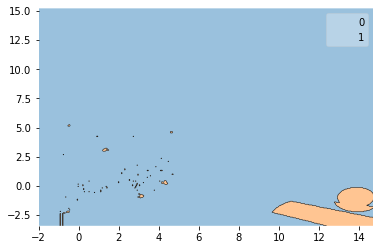

In [40]:
knn_fit = KNeighborsClassifier(n_neighbors=10, weights = 'distance')
knn_fit.fit(X_train, y_train)
plot_decision_regions(
    np.array(X_train), np.array(y_train), knn_fit, scatter_kwargs={"alpha": 0, "s": 1}
)


In [41]:
from sklearn.model_selection import GridSearchCV

In [42]:
parameter_grid = {
    "n_neighbors": range(1, 20),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "chebyshev"],
}
knn_fit = KNeighborsClassifier()
knn_opt = GridSearchCV(estimator=knn_fit, param_grid=parameter_grid, scoring="f1",cv = 5)
knn_opt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'chebyshev'],
                         'n_neighbors': range(1, 20),
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [43]:
knn_opt.best_estimator_

KNeighborsClassifier(metric='manhattan', n_neighbors=1)

/Users/pedroteche/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


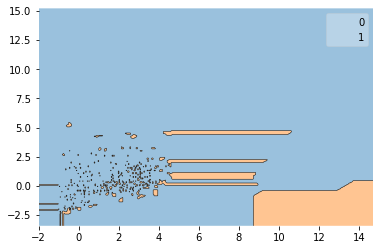

In [44]:
plot_decision_regions(
    np.array(X_train), np.array(y_train), knn_opt, scatter_kwargs={"alpha": 0, "s": 1}
);

In [45]:
tb_p_test["pred_knn"] = knn_opt.predict(X_test)
calcular_erros("pred_knn")

Acurácia: 0.8884696823869105
ROC-AUC Score: 0.568575767144423
Precision: 0.18157614483493079
Recall: 0.2004703115814227
F1-Score: 0.19055602123498186


# SVM

In [46]:
from sklearn.svm import SVC

![title](svm.jpg)

## Hiperparâmetros

https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/

* **C**: parâmetro de regularização, **reduz o overfitting** do modelo simplificando a superficie de decisão
* **kernel**: função utilizada para representar superficies não lineares
* **gamma**: o quão *fechadas* as curvas do kernel podem ser

In [47]:
X_train_svc = X_train[0:5000]
y_train_svc = y_train[0:5000]
svm_fit = SVC(class_weight = 'balanced')
svm_fit.fit(X_train_svc, y_train_svc)

SVC(class_weight='balanced')

/Users/pedroteche/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


<AxesSubplot:>

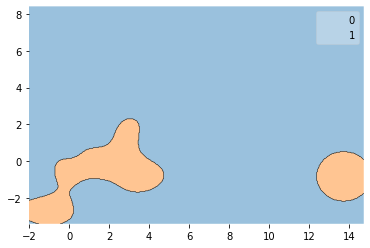

In [48]:
plot_decision_regions(
    np.array(X_train_svc), np.array(y_train_svc), svm_fit, scatter_kwargs={"alpha": 0, "s": 1}
)

In [49]:
tb_p_test["pred_svm"] = svm_fit.predict(X_test)
calcular_erros("pred_svm")

Acurácia: 0.5554571703561116
ROC-AUC Score: 0.5921313558314282
Precision: 0.08988670443185605
Recall: 0.6343327454438565
F1-Score: 0.15746078073695732


In [ ]:
### EXERCICIO
# MONTAR UM OTIMIZADOR DE HIPERPARAMETROS PARA O SVC ACIMA

# Árvores de Decisão

In [50]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

## Hiperparâmetros

https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680

* **max_depth**: profundidade máxima da árvore
* **min_samples_leaf**: número mínimo de amostras em cada nó final (folha) da árvore
* **min_samples_split**: número mínimo de amostras em cada galho

### Fit ingênuo

In [56]:
tree_fit = DecisionTreeClassifier()
tree_fit.fit(X_train, y_train)

DecisionTreeClassifier()

In [57]:
f1_score(y_train, tree_fit.predict(X_train))

0.7379692011549567

In [58]:
f1_score(y_test, tree_fit.predict(X_test))

0.18871866295264625

O que aconteceu??

### Reduzindo Overfitting

Devemos reduzir o overfitting de uma arvore de decisão utilizando os hiperparâmetros dela.

In [61]:
tree_fit = DecisionTreeClassifier(max_depth = 3, min_samples_leaf=0.25, class_weight = "balanced")
tree_fit.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       min_samples_leaf=0.25)

/Users/pedroteche/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


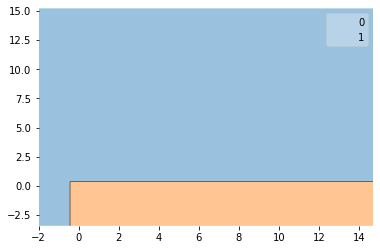

In [60]:
plot_decision_regions(
    np.array(X_train), np.array(y_train), tree_fit, scatter_kwargs={"alpha": 0, "s": 1}
);

[Text(0.4, 0.8333333333333334, 'X[0] <= -0.424\ngini = 0.5\nsamples = 77922\nvalue = [38961.0, 38961.0]'),
 Text(0.2, 0.5, 'gini = 0.484\nsamples = 30514\nvalue = [15564.701, 10899.984]'),
 Text(0.6, 0.5, 'X[1] <= 0.352\ngini = 0.496\nsamples = 47408\nvalue = [23396.299, 28061.016]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.482\nsamples = 26421\nvalue = [12812.132, 18851.363]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.498\nsamples = 20987\nvalue = [10584.168, 9209.653]')]

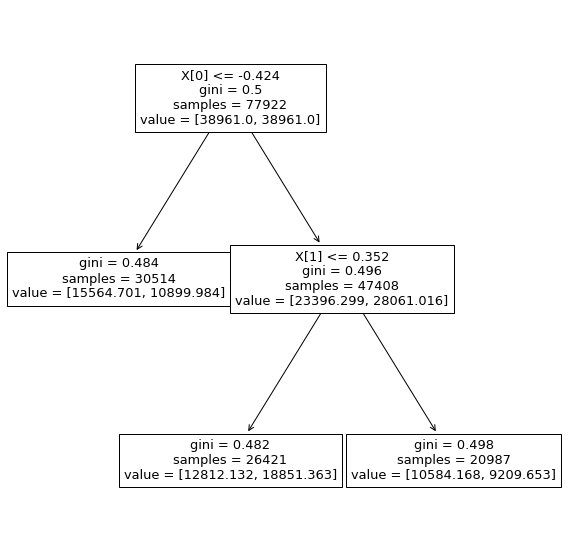

In [55]:
fig = plt.figure(figsize = (10, 10))
plot_tree(tree_fit)

In [62]:
tb_simul_dist["prob_atraso_tree"] = tree_fit.predict_proba(
    tb_simul_dist[["dist", "dias_previstos"]]
)[:, -1]
tb_simul_peso["prob_atraso_tree"] = tree_fit.predict_proba(
    tb_simul_peso[["dist", "dias_previstos"]]
)[:, -1]

Text(0.5, 0.98, 'Simulações usando Modelo Baseline (Reg. Log.)')

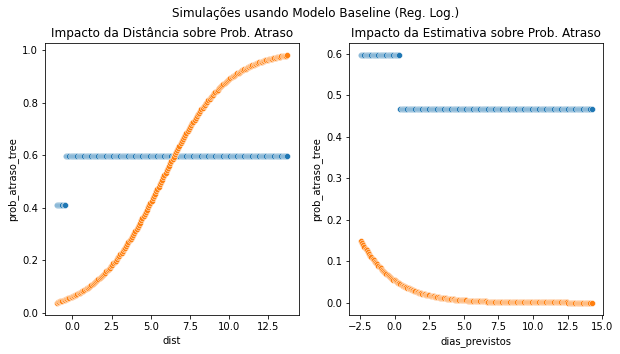

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(data=tb_simul_dist, x="dist", y="prob_atraso_tree", ax=ax[0])
sns.scatterplot(data=tb_simul_dist, x="dist", y="prob_atraso_log", ax=ax[0])
sns.scatterplot(data=tb_simul_peso, x="dias_previstos", y="prob_atraso_tree", ax=ax[1])
sns.scatterplot(data=tb_simul_peso, x="dias_previstos", y="prob_atraso_log", ax=ax[1])
ax[0].set_title("Impacto da Distância sobre Prob. Atraso")
ax[1].set_title("Impacto da Estimativa sobre Prob. Atraso")
fig.suptitle("Simulações usando Modelo Baseline (Reg. Log.)")

In [64]:
tb_p_test["pred_tree"] = tree_fit.predict(X_test)
calcular_erros("pred_tree")

Acurácia: 0.6532050048123196
ROC-AUC Score: 0.5632461811523999
Precision: 0.08815240671852102
Recall: 0.45972957084068194
F1-Score: 0.1479379493000378


In [69]:
max_depth = [int(x) for x in np.linspace(1, 50, 5)]
min_samples_leaf = [int(x) for x in np.linspace(1, 20, 3)]
min_samples_split = [int(x) for x in np.linspace(2, 40, 3)]

In [70]:
min_samples_split

[2, 21, 40]

In [71]:
parameter_grid = {
    "max_depth": max_depth,
    "min_samples_leaf": min_samples_leaf,
    "min_samples_split": min_samples_split,
    "class_weight": ["balanced", None] 
}
tree_fit = DecisionTreeClassifier()
tree_opt = GridSearchCV(estimator=tree_fit, param_grid=parameter_grid, scoring="f1",cv = 5)
tree_opt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [1, 13, 25, 37, 50],
                         'min_samples_leaf': [1, 10, 20],
                         'min_samples_split': [2, 21, 40]},
             scoring='f1')

In [72]:
tree_opt.best_estimator_

DecisionTreeClassifier(class_weight='balanced', max_depth=50)

In [73]:
tb_p_test["pred_tree"] = tree_opt.predict(X_test)
calcular_erros("pred_tree")

Acurácia: 0.823330125120308
ROC-AUC Score: 0.610260700913251
Precision: 0.15036319612590798
Recall: 0.36507936507936506
F1-Score: 0.21299948550848907


/Users/pedroteche/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


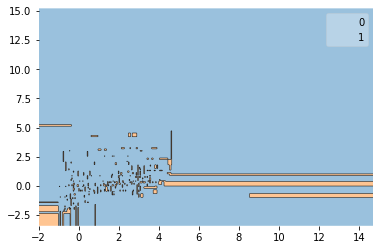

In [74]:
plot_decision_regions(
    np.array(X_train), np.array(y_train), tree_opt, scatter_kwargs={"alpha": 0, "s": 1}
);

# Ensembles

https://scikit-learn.org/stable/modules/ensemble.html

![title](ensemble.png)

## Bagging

In [76]:
from sklearn.ensemble import RandomForestClassifier

![title](rf.png)

### Hiperparâmetros

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

* **n_estimators**: número de arvores de decisão
* **max_samples**: número de pontos em cada amostra


Parâmetros do classificador bagged
* **max_depth**: profundidade máxima da árvore (**CRITICO PARA ENSEMBLES!!**)
* **min_samples_leaf**: número mínimo de amostras em cada nó final (folha) da árvore
* **min_samples_split**: número mínimo de amostras em cada galho

In [77]:
rf_fit = RandomForestClassifier(n_estimators = 1000, class_weight = "balanced", max_depth = 8)
rf_fit.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=1000)

/Users/pedroteche/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


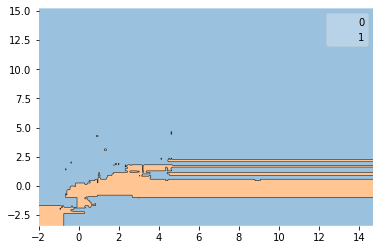

In [78]:
plot_decision_regions(
    np.array(X_train), np.array(y_train), rf_fit, scatter_kwargs={"alpha": 0., "s": 1}
);

In [79]:
tb_p_test["rf_fit"] = rf_fit.predict(X_test)
calcular_erros("rf_fit")

Acurácia: 0.6210587102983638
ROC-AUC Score: 0.6026294479394733
Precision: 0.09772727272727273
Recall: 0.5814226925338036
F1-Score: 0.16732932915996954


In [80]:
rf_fit = RandomForestClassifier(n_estimators = 10000, max_depth = 2, class_weight = "balanced")
rf_fit.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=2, n_estimators=10000)

/Users/pedroteche/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


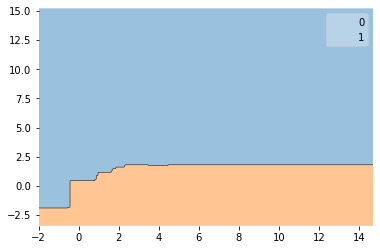

In [81]:
plot_decision_regions(
    np.array(X_train), np.array(y_train), rf_fit, scatter_kwargs={"alpha": 0., "s": 1}
);

In [82]:
tb_p_test["rf_fit"] = rf_fit.predict(X_test)
calcular_erros("rf_fit")

Acurácia: 0.5610009624639076
ROC-AUC Score: 0.5860770557107744
Precision: 0.08868916398168561
Recall: 0.6149323927101705
F1-Score: 0.15502037791774734


## Boosting

In [84]:
from sklearn.ensemble import GradientBoostingClassifier

https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/

![title](boosting.png)

### Hiperparâmetros

https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae

* **learning_rate**: reduz a contribuição de cada modelo para reduzir overfitting
* **n_estimator**: numero de modelos em séries

Parâmetros do classificador boosted

* **max_depth**: profundidade máxima da árvore (**CRITICO PARA ENSEMBLES!!**)
* **min_samples_leaf**: número mínimo de amostras em cada nó final (folha) da árvore
* **min_samples_split**: número mínimo de amostras em cada galho

In [85]:
gb_fit = GradientBoostingClassifier(n_estimators = 100, max_depth = 8)
gb_fit.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=8)

/Users/pedroteche/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


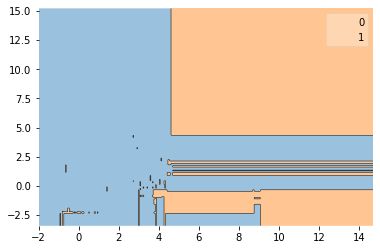

In [86]:
plot_decision_regions(
    np.array(X_train), np.array(y_train), gb_fit, scatter_kwargs={"alpha": 0., "s": 1}
);

In [87]:
tb_p_test["pred_gb"] = gb_fit.predict(X_test)
calcular_erros("pred_gb")

Acurácia: 0.9338594802694898
ROC-AUC Score: 0.5086702678227218
Precision: 0.39759036144578314
Recall: 0.019400352733686066
F1-Score: 0.03699551569506726


In [96]:
from sklearn.model_selection import RandomizedSearchCV

In [97]:
learning_rate = np.linspace(0.05, 0.8, 20)
n_estimators = [int(x) for x in np.linspace(800, 2000, 20)]
max_depth = range(1, 6)
parameter_grid = {
    "max_depth": max_depth,
    "n_estimators" : n_estimators,
    "learning_rate": learning_rate
}
gb_fit = GradientBoostingClassifier()
gb_opt = RandomizedSearchCV(estimator=gb_fit, param_distributions=parameter_grid, scoring="f1",cv = 5, n_iter = 5)
gb_opt.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=5,
                   param_distributions={'learning_rate': array([0.05      , 0.08947368, 0.12894737, 0.16842105, 0.20789474,
       0.24736842, 0.28684211, 0.32631579, 0.36578947, 0.40526316,
       0.44473684, 0.48421053, 0.52368421, 0.56315789, 0.60263158,
       0.64210526, 0.68157895, 0.72105263, 0.76052632, 0.8       ]),
                                        'max_depth': range(1, 6),
                                        'n_estimators': [800, 863, 926, 989,
                                                         1052, 1115, 1178, 1242,
                                                         1305, 1368, 1431, 1494,
                                                         1557, 1621, 1684, 1747,
                                                         1810, 1873, 1936,
                                                         2000]},
                   scoring='f1')

In [ ]:
gb_opt.cv_results_

<AxesSubplot:xlabel='param_max_depth', ylabel='mean_test_score'>

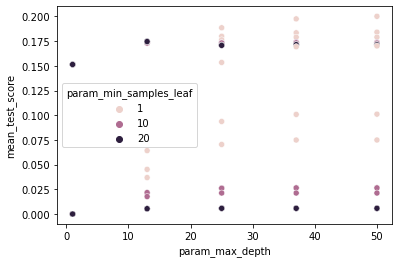

In [94]:
sns.scatterplot(data = pd.DataFrame(tree_opt.cv_results_),
                x = 'param_max_depth',
                y = 'mean_test_score',
               hue = 'param_min_samples_leaf')

In [93]:
pd.DataFrame(tree_opt.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.024623,0.008023,0.004033,0.000401,balanced,1,1,2,"{'class_weight': 'balanced', 'max_depth': 1, '...",0.139959,0.141682,0.159813,0.165601,0.149687,0.151348,0.010007,40
1,0.016372,0.000556,0.003204,0.000114,balanced,1,1,21,"{'class_weight': 'balanced', 'max_depth': 1, '...",0.139959,0.141682,0.159813,0.165601,0.149687,0.151348,0.010007,40
2,0.016467,0.001206,0.003362,0.000372,balanced,1,1,40,"{'class_weight': 'balanced', 'max_depth': 1, '...",0.139959,0.141682,0.159813,0.165601,0.149687,0.151348,0.010007,40
3,0.015537,0.000121,0.002985,0.000022,balanced,1,10,2,"{'class_weight': 'balanced', 'max_depth': 1, '...",0.139959,0.141682,0.159813,0.165601,0.149687,0.151348,0.010007,40
4,0.015771,0.000251,0.003206,0.000194,balanced,1,10,21,"{'class_weight': 'balanced', 'max_depth': 1, '...",0.139959,0.141682,0.159813,0.165601,0.149687,0.151348,0.010007,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.087618,0.001740,0.004935,0.000286,None,50,10,21,"{'class_weight': None, 'max_depth': 50, 'min_s...",0.034735,0.034608,0.022367,0.018692,0.021858,0.026452,0.006829,58
86,0.086087,0.001326,0.004689,0.000248,None,50,10,40,"{'class_weight': None, 'max_depth': 50, 'min_s...",0.027650,0.013208,0.026071,0.022430,0.016838,0.021239,0.005472,66
87,0.081847,0.002187,0.004477,0.000021,None,50,20,2,"{'class_weight': None, 'max_depth': 50, 'min_s...",0.009506,0.005764,0.009597,0.001919,0.001938,0.005745,0.003409,70
88,0.080553,0.001865,0.004409,0.000104,None,50,20,21,"{'class_weight': None, 'max_depth': 50, 'min_s...",0.009506,0.005764,0.009597,0.001919,0.001938,0.005745,0.003409,70


# Onde praticar

In [75]:
from sklearn import datasets

## Iris
https://en.wikipedia.org/wiki/Iris_flower_data_set

In [ ]:
tb_iris = datasets.load_iris()

## Wisconsin Breast Cancer

https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset

https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)

In [ ]:
tb_cancer = datasets.load_breast_cancer()